## Assigment: Neural network basics

Soft deadline: 16.09.18 at 23.59

Hard deadline: 18.09.18 at 23.59

For this task I intentionally provide no boilerplate code, because very puprpose of this task is getting you comforatable with basic code template for desiging NNs in pytorch. I higly recommend you to revisit all the last seminar materials.

#### Task

* Implement simple **fully-convolutional** neural architecture for classification. Make sure it is small enought to run on your home machine.
* Provide dataset visulization.
* Provide train/test split and validation

#### Requirements

* Architecture should derive from `torch.nn.Module`
* Use `torch.utils.data.Dataset` and `torch.utils.data.DataLoader`. But if you manage co simplify this step using dataset `torchivision`, I will only encourage you.
* Implement at least one data transformer, but make sure it is useful for classification task.
* Use FashionMNIST dataset https://github.com/zalandoresearch/fashion-mnist
* Make sure you can fix random seed for all components of your code to make experiments reproducible
* Since you architecure should be fully-convolutional, make sure it does not depend on input size.

In [46]:
import torch
from IPython import display
import matplotlib.pyplot as plt
import numpy as np

import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

dataset_folder = './dataset'

torch.manual_seed(1)
np.random.seed(1)

def get_transformer():
    dataset = FashionMNIST(dataset_folder, train=True, download=True, transform=transforms.ToTensor())
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)
    mean = torch.zeros(1)
    std = torch.zeros(1)
    N = 0
    
    for batch, _ in iter(dataloader):
        mean += batch.mean()
        std += batch.std()
        
        N += 1
        
    mean /= N
    std /= N
    return transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(mean, std)])

transformer = get_transformer()

training_dataset = FashionMNIST(dataset_folder, train=True, download=True, transform=transformer)
test_dataset = FashionMNIST(dataset_folder, train=False, download=True, transform=transformer)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


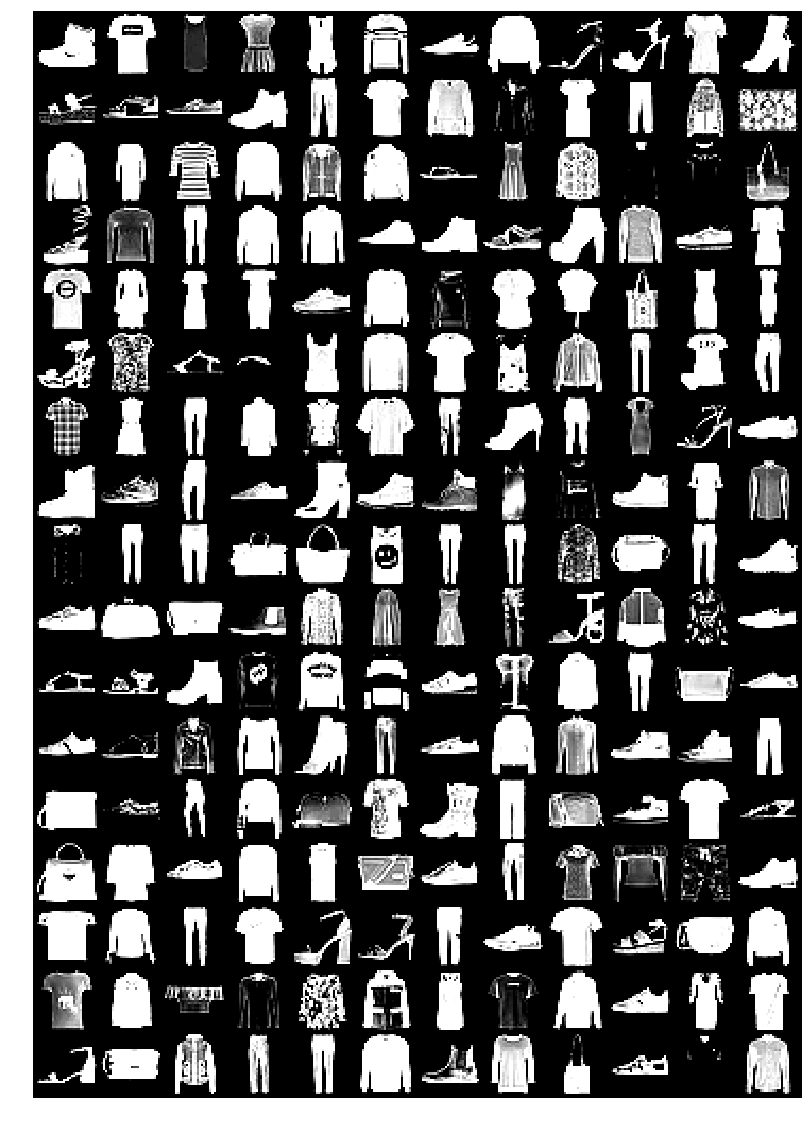

In [47]:
def visualize(data_objects):
    img = torchvision.utils.make_grid(torch.Tensor(data_objects), nrow=12).numpy()
    plt.figure(figsize=(20, 20))
    plt.axis('off')
    out = np.transpose(img, [1, 2, 0])
    plt.imshow(out)
    plt.show()
    
loader = torch.utils.data.DataLoader(training_dataset,
                                     batch_size=204,
                                     shuffle=False)
X, y = iter(loader).next()
visualize(X)

In [6]:
class MyConvNet(torch.nn.Module):
    def __init__(self):
        super(MyConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 10, 5, 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.fc1 = nn.Linear(20, 60)
        self.fc2 = nn.Linear(60, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    


In [ ]:
def train(network, training_dataset, test_dataset, batch=100, epochs=20):
    train_loader = DataLoader(training_dataset, batch_size=batch, shuffle=True)
    test_loader  = DataLoader(test_dataset, batch_size=batch, shuffle=True)
    loss = nn.CrossEntropyLoss()
    optim = torch.optim.Adam(network.parameters(), lr=1e-3)
    
    def avg_value(data, N):
        s = 0.0
        for input_data, labels in data:
            outputs = network(input_data)
            s += loss(outputs, labels).item()

        return s / N
    
    def get_accuracy(data, N):
        corr = 0.0
        for input_data, labels in data:
            outputs = network(input_data)
                
            _, pred = torch.max(outputs.data, dim=1)
            corr += (pred == labels).sum()

        accuracy = 100.0 * corr.item() / N
        return accuracy
    
    train_losses = []
    test_losses = []
    tr_acc = []
    test_acc = []
    tr_len = len(training_dataset)
    test_len = len(test_dataset)
    for epoch in range(epochs):
        print("Training epoch ", epoch + 1)
        for input_data, labels in train_loader:
            optim.zero_grad()
            outputs = network(input_data)

            loss_val = loss(outputs, labels)
            loss_val.backward()
            optim.step()
        
        train_losses.append(avg_value(train_loader, tr_len))
        test_losses.append(avg_value(test_loader, test_len))
        
        tr_acc.append(get_accuracy(train_loader, tr_len))
        test_acc.append(get_accuracy(test_loader, test_len))
        
    
    return train_losses, test_losses, tr_acc, test_acc
        
train_losses, test_losses, tr_acc, test_acc = train(MyConvNet(), training_dataset, test_dataset)

Training epoch  1
Training epoch  2
Training epoch  3
Training epoch  4
Training epoch  5
Training epoch  6
Training epoch  7
Training epoch  8
Training epoch  9
Training epoch  10
Training epoch  11
Training epoch  12
Training epoch  13
Training epoch  14
Training epoch  15
Training epoch  16
Training epoch  17
Training epoch  18
Training epoch  19


plt.clf()
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

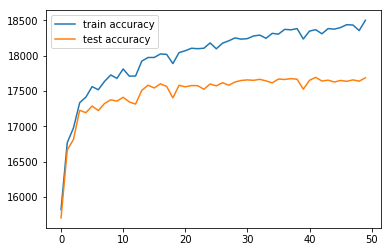

In [53]:
plt.clf()
plt.plot(tr_acc, label='train accuracy')
plt.plot(test_acc, label='test accuracy')
plt.legend()
plt.show()